In [1]:
!pip install sentence-transformers
from sentence_transformers import SentenceTransformer

     |████████████████████████████████| 61kB 1.7MB/s 
     |████████████████████████████████| 665kB 6.2MB/s 
     |████████████████████████████████| 1.1MB 13.4MB/s 
     |████████████████████████████████| 890kB 16.7MB/s 
     |████████████████████████████████| 3.8MB 28.5MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=e3e3d1b9632271bbc0bc7eaec5a292bc81ad10e0df411b12086f398f47eac924
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=6872ea29fdcc541423b78278db67c04928c717487872852a149c556eb226c08d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [2]:
random_sentence = ["Three children playing in the water", 
                   "The big blue sky and some raining clouds",
                   "The big blue ocean, next to a river with the smell of the sea and water",
                   "Juan, Ely and Paola finishing the project"]

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
random_embeddings = model.encode(random_sentence)

100%|██████████| 405M/405M [00:48<00:00, 8.33MB/s]


In [0]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
random_embeddings = model.encode(random_sentence)

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import os
os.chdir("/content/drive/My Drive/text-to-image")
os.listdir()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


['model',
 'Flickr8k_Dataset',
 'data',
 'Flickr8k_text',
 'src-juan',
 'src-paola',
 'src-ely',
 'resultados_pasados',
 'pickles',
 'logs',
 'src-clean',
 'ToDo.gdoc',
 'my.png',
 'model.png',
 'random_test',
 '8min.gslides',
 'JEP_presentation.gslides']

In [0]:
#EMB_SHAPE = 1024
EMB_SHAPE =768

import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate, ZeroPadding2D
from keras.layers import add
from keras.optimizers import Adam
from matplotlib import pyplot as plt

def build_ca_model():
    """
    Get conditioning augmentation model.
    Takes an embedding of shape (1024,) and returns a tensor of shape (256,)
    """
    input_layer = Input(shape=(EMB_SHAPE ,))
    x = Dense(256)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model

def build_embedding_compressor_model():
    """
    Build embedding compressor model
    """
    input_layer = Input(shape=(EMB_SHAPE ,))
    x = Dense(128)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    model = Model(inputs=[input_layer], outputs=[x])
    return model
  
def generate_c(x):
    mean = x[:, :128]
    log_sigma = x[:, 128:]

    stddev = K.exp(log_sigma)
    epsilon = K.random_normal(shape=K.constant((mean.shape[1],), dtype='int32'))
    c = stddev * epsilon + mean

    return c

def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    input_layer = Input(shape=(EMB_SHAPE ,))
    x = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(x)

    c = Lambda(generate_c)(mean_logsigma)

    input_layer2 = Input(shape=(100,))

    gen_input = Concatenate(axis=1)([c, input_layer2])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = LeakyReLU(alpha=0.2)(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, input_layer2], outputs=[x, mean_logsigma])
    return stage1_gen
  
def residual_block(input):
    """
    Residual block in the generator network
    """
    x = Conv2D(128 * 4, kernel_size=(3, 3), padding='same', strides=1)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128 * 4, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = add([x, input])
    x =LeakyReLU(alpha=0.2)(x)

    return x
  
def joint_block(inputs):
    c = inputs[0]
    x = inputs[1]

    c = K.expand_dims(c, axis=1)
    c = K.expand_dims(c, axis=1)
    c = K.tile(c, [1, 16, 16, 1])
    return K.concatenate([c, x], axis=3)
  
def build_stage2_generator():
    """
    Create Stage-II generator containing the CA Augmentation Network,
    the image encoder and the generator network
    """

    # 1. CA Augmentation Network
    input_layer = Input(shape=(EMB_SHAPE ,))
    input_lr_images = Input(shape=(64, 64, 3))

    ca = Dense(256)(input_layer)
    mean_logsigma = LeakyReLU(alpha=0.2)(ca)
    c = Lambda(generate_c)(mean_logsigma)

    # 2. Image Encoder
    x = ZeroPadding2D(padding=(1, 1))(input_lr_images)
    x = Conv2D(128, kernel_size=(3, 3), strides=1, use_bias=False)(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(256, kernel_size=(4, 4), strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(512, kernel_size=(4, 4), strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 3. Joint
    c_code = Lambda(joint_block)([c, x])

    x = ZeroPadding2D(padding=(1, 1))(c_code)
    x = Conv2D(512, kernel_size=(3, 3), strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # 4. Residual blocks
    x = residual_block(x)
    x = residual_block(x)
    x = residual_block(x)
    x = residual_block(x)

    # 5. Upsampling blocks
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x =LeakyReLU(alpha=0.2)(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation('tanh')(x)

    model = Model(inputs=[input_layer, input_lr_images], outputs=[x, mean_logsigma])
    return model
  
def build_stage2_discriminator():
    """
    Create Stage-II discriminator network
    """
    input_layer = Input(shape=(256, 256, 3))

    x = Conv2D(64, (4, 4), padding='same', strides=2, input_shape=(256, 256, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(2048, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)

    x2 = Conv2D(128, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2D(128, (3, 3), padding='same', strides=1, use_bias=False)(x2)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2D(512, (3, 3), padding='same', strides=1, use_bias=False)(x2)
    x2 = BatchNormalization()(x2)

    added_x = add([x, x2])
    added_x = LeakyReLU(alpha=0.2)(added_x)

    input_layer2 = Input(shape=(4, 4, 128))

    merged_input = concatenate([added_x, input_layer2])

    x3 = Conv2D(64 * 8, kernel_size=1, padding="same", strides=1)(merged_input)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(alpha=0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(1)(x3)
    x3 = Activation('sigmoid')(x3)

    stage2_dis = Model(inputs=[input_layer, input_layer2], outputs=[x3])
    return stage2_dis
  
def build_adversarial_model(gen_model2, dis_model, gen_model1):
    """
    Create adversarial model
    """
    embeddings_input_layer = Input(shape=(EMB_SHAPE , ))
    noise_input_layer = Input(shape=(100, ))
    compressed_embedding_input_layer = Input(shape=(4, 4, 128))

    gen_model1.trainable = False
    dis_model.trainable = False

    lr_images, mean_logsigma1 = gen_model1([embeddings_input_layer, noise_input_layer])
    hr_images, mean_logsigma2 = gen_model2([embeddings_input_layer, lr_images])
    valid = dis_model([hr_images, compressed_embedding_input_layer])

    model = Model(inputs=[embeddings_input_layer, noise_input_layer, compressed_embedding_input_layer], outputs=[valid, mean_logsigma2])
    return model



def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss


def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)



def write_log2(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    writer = tf.summary.create_file_writer("./src-paola/logs256/")
    with writer.as_default():
      tf.summary.scalar(name, loss,batch_no)
    writer.flush()

def write_log2(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    writer = tf.summary.create_file_writer("/logs")
    with writer.as_default():
      tf.summary.scalar(name, loss,batch_no)
    writer.flush()

def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()

In [0]:
hr_image_size = (256, 256)
lr_image_size = (64, 64)
batch_size = 32
z_dim = 100
stage1_generator_lr = 0.0002
stage1_discriminator_lr = 0.0002
stage1_lr_decay_step = 600
epochs = 2000
condition_dim = 128

# Define optimizers
dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)


"""
Build and compile models
"""
stage2_dis = build_stage2_discriminator()
stage2_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

# Cargamos pesos pasados
stage2_dis.load_weights("./src-paola/GRIDSEARCH/models/stage2_2_BATCH_128_dis_256_60.h5")

stage1_gen = build_stage1_generator()
stage1_gen.compile(loss="binary_crossentropy", optimizer=gen_optimizer)
stage1_gen.load_weights("./src-paola/GRIDSEARCH/results/find_best/models/stage1_gen_300.h5")

stage2_gen = build_stage2_generator()
stage2_gen.compile(loss="binary_crossentropy", optimizer=gen_optimizer)

#Aqui tambien
stage2_gen.load_weights("./src-paola/GRIDSEARCH/models/stage2_2_BATCH_128_gen_256_60.h5")


embedding_compressor_model = build_embedding_compressor_model()
embedding_compressor_model.compile(loss='binary_crossentropy', optimizer='adam')

adversarial_model = build_adversarial_model(stage2_gen, stage2_dis, stage1_gen)
adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1.0, 2.0],
                          optimizer=gen_optimizer, metrics=None)

In [11]:
random_sentence = ["a dog in the grass"]

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
random_embeddings = model.encode(random_sentence)

batch_size = len(random_sentence)
index = 0

# Create a noise vector
z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
embedding_batch = random_embeddings[index * batch_size:(index + 1) * batch_size]
lemma_batch = random_sentence 

# Generate fake images
lr_fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)
hr_fake_images, _ = stage2_gen.predict([embedding_batch, lr_fake_images], verbose=3)

# GUARDA TRAIN
for i, img in enumerate(lr_fake_images):
    save_rgb_img(img, "./random_test/LowR/gen_lr_{}_{}.png".format(lemma_batch[i], i+64*index))   

for i, img in enumerate(hr_fake_images):
    save_rgb_img(img, "./random_test/HighR/gen_hr_{}_{}.png".format(random_sentence[i], i+64*index))   


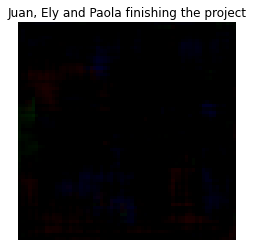

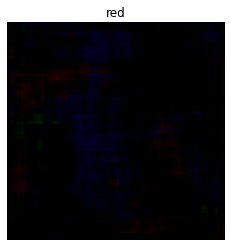

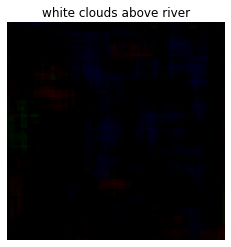

In [0]:
def plot_rgb_img(img, title):
    """
    Plot an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)
    
random_sentence = ["this isn't working at all oh my god",
                   "black dog frisbee",
                   "black dog playing with a boy",
                   "a little girl plays whith a puppy on the grass",
                   "a little girl plays whith a puppy at the beach"]

random_sentence = ["Juan, Ely and Paola finishing the project",
                   "red",
                   "white clouds above river"]

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')
random_embeddings = model.encode(random_sentence)

batch_size = len(random_sentence)
index = 0

# Create a noise vector
z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
embedding_batch = random_embeddings[index * batch_size:(index + 1) * batch_size]
lemma_batch = random_sentence 

# Generate fake images
lr_fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)
#hr_fake_images, _ = stage2_gen.predict([embedding_batch, lr_fake_images], verbose=3)

for i, img in enumerate(lr_fake_images):
    plot_rgb_img(img, random_sentence[i]) 

#for i, img in enumerate(hr_fake_images):
#    plot_rgb_img(img, random_sentence[i]) 

In [0]:
random_sentence = ["red fire in woods", "white clouds in blue sky",
                   "white clouds above a pool",
                   "a river with water flowing and white clouds",
                   "water in river and sea with blue drops",
                   "sky full of clouds,"
                   "wave", "surf", "sky", "water", "sea", "cloud", "white", "black", "red", "dog",
                   "A man surfing a big wave in the ocean with water and blue sky"
                   "Three children playing in the water", 
                   "The big blue sky and some raining clouds",
                   "The big blue ocean, next to a river with the smell of the sea and water",
                   "Juan, Ely and Paola finishing the project"]